# Cerebellar Model Articulation Controller(CMAC)


## 概论
小脑模型的初始设想很简单，希望设计一个这样的模型：

1. **足够快**
2. **拟合**

### 足够快
对于第一点，传统的神经网络均是使用浮点数进行计算，使用浮点数显然存在两个缺点：其一是占用空间大，其二是运算不够快。但也存在非常明显的优点：计算精度高。

若为了在不太降低精度的条件下尽可能提高模型运算效率，显然有两个角度：其一是改进模型，其二是改变数值存储方式。

量化技术就是这样一类通过改变数值存储方式提高模型运算效率的方式。对于现代神经网络，训练通常采用32位浮点数，推理时则可以选用16位浮点数以提高精度，而当部署到边缘设备上时则可以进一步采用**int8量化技术**。

对于CMAC，同样的，为了提升运算效率，初始数据输入时会进行量化。此外，为了进一步提升效率，CMAC还引入了**哈希散列**，通过查表的方式将相近的输入映射到相似的地址上。

哈希散列同时也引入了不确定的因素。哈希散列是一种压缩映射，其很有可能将不同的输入映射到同一个地址，即导致了**碰撞**。从另一个角度讲，这也引入了非线性变换，即在原空间可能相隔非常远的两个输入，在映射后可能十分相近甚至发生**碰撞**。


### 拟合
为了实现拟合，CMAC在查表后建立了一个自适应线性层，实现地址到输出的线性估计
由于采用了哈希，实际上建立了输入与地址的映射表。在不考虑碰撞的情况下，一个特定的输入会激活特定的地址，而特定的地址会激活特定的自适应线性层的输入单元，这些单元则会连接到输出。

不同于传统的神经网络，进行推理时同层所有的神经元均会参与运算，CMAC中仅有被激活的输入单元才会参与运算，这显然也加速了CMAC的运算速度。


## 符号定义

### 空间
|符号|含义|
|:-:|:-:|
|$S$|输入空间|
|$M$|扩充地址空间|
|$MC$|扩充地址空间长度|
|$A_c$|虚拟存储空间|
|$A_p$|实际存储空间|
|$F$|输出空间|

### 数据
|符号|含义|
|:-:|:-:|
|$\bm{s}$|输入向量|
|$\bm{m}$|扩充后矩阵|
|$\bm{a}$|虚拟存储空间向量|
|$\bm{d}$|实际存储空间向量|
|$\hat{y}$|预测输出|
|$y$|真实输出|

### 参数
|符号|含义|
|:-:|:-:|
|s|输入空间维度|
|q|量化级|
|c|扩充地址维度|
|$N_p$|用于Hash运算的质数|
|$\bm{W}$|权矩阵|

## 正向运算

CMAC的整体流程如下：

* 输入空间$S$离散化
* 输入空间$S$ $\rightarrow$ 扩充地址空间$M$
* 扩充地址空间$M$ $\rightarrow$ 虚拟存储空间$A_c$
* 虚拟存储空间$A_c$ $\rightarrow$ 实际存储空间$A_p$
* 实际存储空间$A_p$ $\rightarrow$ 输出空间$F$

第零步为离散化。一方面是加速运算，另一方面也是配合后续的Hash

第一步是在进行升维

第二步是将第一步中升维到高维的多个分量组合为一个向量

第三步为Hash

第四步为自适应线性拟合

### 离散化

输入为$\bm{s}=[s_1, s_2, \cdots, s_s]$

设定第n个维度的取值范围为$[n_{min}, n_{max}]$，量化级为q_n

则第n个维度的离散值为
$$
\begin{equation}
    s_n = \lceil\frac{(s_n-n_{min})}{(n_{max}-n_{min})}*(q_n-1)\rceil + 1
\end{equation}
$$

### 输入空间到扩充地址空间

每一个输入分量均扩充到c维

对于一个特定的输入分量$s_n$，有对应的扩充后向量$\bm{m_n}$

扩充后向量按照如下的方式进行运算

定义如下的取余运算
$$
\begin{equation}
    \Psi(s_n) = mod(\frac{s_n-1}{c})+1
\end{equation}
$$
则$\bm{m_n}$的第$\Psi(s_n)$位为$s_n$，其他位依次推出

|$\bm{m_{n1}}$|$\bm{m_{n2}}$|$\cdots$|$\bm{m_{n\Psi(s_n)}}$|$\cdots$|$\bm{m_{nc}}$|
|:-:|:-:|:-:|:-:|:-:|:-:|
|$s_n+(c-\Psi(s_n)+1)$|$s_n+(c-\Psi(s_n)+2)$|$\cdots$|$s_n$|$\cdots$|$s_n+(c-\Psi(s_n))$|

### 扩充地址空间到虚拟存储空间

扩充地址空间为一个$s\times c$的矩阵，转换到虚拟存储空间后进行纵向连接，即进行如下操作

$$
\begin{equation}
    \bm{m} = 
    \left[\begin{array}{cc}
        m_{11}&m_{12}&\cdots&m_{1c} \\
        \vdots&\ddots&\ddots&\vdots \\
        m_{s1}&m_{s2}&\cdots&m_{sc}
    \end{array}\right]
\end{equation}
$$

$$
\begin{equation}
    \begin{split}
        \bm{a} 
        &= [a_1, a_2, \cdots, a_c]^T \\
        &= [m_{11}m_{21}\cdots m_{s1}, m_{12}m_{22}\cdots m_{s2}, \cdots, m_{1c}m_{2c}\cdots m_{sc}]^T 
    \end{split}
\end{equation}
$$

### 虚拟存储空间到实际存储空间

这一步即为Hash，在这里采用取余运算的方式，类似于式2有：

$$
\begin{equation}
    \Psi(a_n) = mod(\frac{a_n-1}{N_p})+1
\end{equation}
$$

$$
\begin{equation}
    \begin{split}
        \bm{d} 
        &= [d_1, d_2, \cdots, d_c]^T \\
        &= [\Psi(a_1), \Psi(a_2), \cdots, \Psi(a_c)]^T
    \end{split}
\end{equation}
$$


### 实际存储空间到输出空间

这一步采用简单的线性变换

上述得到的是地址，在CMAC中，为了加速运算，最终一步是通过查询实现的，

权矩阵$\bm{W}\in\mathcal{R}^{c \times N_p}$

其中$c$为地址的维度，$N_p$为取余运算的除数，对于以$N_p$为底的除法，显然得到的余数不可能大于$N_p$

输出即为对应地址位置的权值之和

$$
\begin{equation}
    \hat{y} = \sum_{i=0}^{c}W[i, \Psi(a_i)]
\end{equation}
$$

上述方法均是在从1开始计数的背景下讨论的，在具体实现中将从0开始计数

## 参数学习

定义损失函数

$$
\begin{equation}
    \mathcal{L} = ||\hat{y}-y||_2^2
\end{equation}
$$

对权值求偏导

$$
\begin{equation}
    \begin{split}
    \frac{\partial \mathcal{L}}{\partial \bm{W}} 
    &= \frac{||\hat{y}-y||_2^2}{\partial \bm{W}} \\
    &= \frac{(\sum_{i=0}^{c}W[i, \Psi(a_i)]-y)^2}{\partial \bm{W}} \\
    &= 2(\sum_{i=0}^{c}W[i, \Psi(a_i)]-y)\frac{\sum_{i=0}^{c}W[i, \Psi(a_i)]}{\partial \bm{W}}
    \end{split}
\end{equation}
$$

$$
\begin{equation}
    \frac{\partial \mathcal{L}}{W_{ij}} = 
    \left\{
    \begin{array}{cc}
    0,&d_i \neq j+1 \\
    2(\sum_{i=0}^{c}W[i, \Psi(a_i)]-y),&else
    \end{array}
    \right. 
\end{equation}
$$

获得参数更新函数

$$
\begin{equation}
    \bm{W}(t+1) = \bm{W}(t) - \eta\frac{\partial \mathcal{L}}{\bm{W}(t)}
\end{equation}
$$

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import seaborn as sn
import imageio

%matplotlib inline

In [2]:
class CMAC(object):

    def __init__(self, 
                 input_dim, 
                 input_range,  
                 q_level, 
                 expend_dim, 
                 hash_number):
        """
        input_dim: 输入维度
        input_range: 输入取值范围，默认需要一个list
        q_level: 量化级，默认需要输入一个list
        expend_dim: 扩充地址维度
        hash_number: 用于散列的质数
        """

        self.input_dim = input_dim
        self.input_range = np.array(input_range)
        self.q_level = q_level
        self.expend_dim = expend_dim
        self.hash_number = hash_number

        # 输出权值矩阵
        random.seed(1024)
        np.random.seed(1024)
        self.weight_matrix = np.zeros((self.expend_dim, self.hash_number))

        # 数据存储空间向量
        self.real_vector = None
        self.output_vector = None
    
    def forward(self, x):
        """
        x: 输入向量
        """

        # ------------- 离散化 ---------------
        input_q = self._quantification(np.array(x))
        
        # ------------- 输入空间到扩充地址空间 ------------------
        # (self.expend_dim, self.input_dim)
        expend_matrix = self._input2expend(input_q)

        # ------------- 扩充地址空间到虚拟存储空间 -----------------
        # (self.expend_dim, 1)
        virtual_vector = self._expend2virtual(expend_matrix)

        # ------------- 虚拟存储空间到实际存储空间 ------------------
        # (self.expend_dim, 1)
        self.real_vector = self._virtual2real(virtual_vector)

        # ------------- 实际存储空间到输出空间 --------------------
        # (self.output_dim, 1)
        self.output_value = self._real2output(self.real_vector)

        return self.output_value
    
    def optim(self, true_output, lr):
        """
        true_output: 真实输出
        """

        # 更新mask
        partial_matrix = np.zeros((self.expend_dim, self.hash_number))
        partial_matrix[range(0, self.expend_dim), self.real_vector.reshape(-1)] = 1
        self.weight_matrix -= lr * (self.output_value - true_output) * partial_matrix

    def _quantification(self, input_vector):
        """
        input_vector: 输入向量
        """
        input_q = np.zeros(self.input_dim, dtype=np.int32)
        # (self.input_dim)
        for i in range(self.input_dim):
            _input_range = self.input_range[i, :]
            input_q[i] = np.math.ceil((input_vector[i]-_input_range[0])*(self.q_level[i]-1)/(_input_range[1]-_input_range[0]))

        return input_q

    def _input2expend(self, input_q):
        """
        input_q: 量化后的输入向量
        """
        expend_matrix = np.zeros((self.input_dim, self.expend_dim))

        for i in range(self.input_dim):
            
            # 计算取余运算
            phi_ = input_q[i] % self.expend_dim
            
            if phi_ != 0:
                # index < phi_
                add_number_list_1 = np.array(range(0, phi_))
                # index > phi_
                add_number_list_2 = np.array(range(0, self.expend_dim-phi_))

                expend_matrix[i, :phi_] = input_q[i] + self.expend_dim - phi_ + add_number_list_1
                expend_matrix[i, phi_:] = input_q[i] + add_number_list_2
            else:
                expend_matrix[i] = input_q[i] + np.array(range(0, self.expend_dim))

        return expend_matrix.astype(np.int32).T

    def _expend2virtual(self, expend_matrix):
        """
        expend_matrix: 扩充地址空间矩阵
        """
        virtual_vector = np.zeros((self.expend_dim, 1), dtype=np.int32)

        # 进行组合
        mul_num = 1
        for i in range(self.input_dim):
            virtual_vector += expend_matrix[:, i:i+1] * mul_num
            mul_num *= self.q_level[i] + self.expend_dim - 1
    
        return virtual_vector
    
    def _virtual2real(self, virtual_vector):
        """
        virtual_vector: 虚拟存储空间向量
        """
        real_vector = np.zeros((self.expend_dim, 1), dtype=np.int32)
        for i in range(self.expend_dim):
            real_vector[i] = virtual_vector[i]%self.hash_number

        return real_vector

    def _real2output(self, real_vector):
        """
        real_vector: 实际存储空间向量
        """
        output_value = np.sum(self.weight_matrix[range(0, self.expend_dim), real_vector.reshape(-1)])

        return output_value

In [3]:
# 测试数据

# 输入维度
input_dim = 2
# 输入范围
input_range = [[0, 6.2], [0, 6.2]]
# 量化级
q_levle = [62, 62]
# 扩充地址空间维度
expend_dim = 7
# 散列质数
hash_number = 5001
# 学习率
lr = 0.1
# 输出维度
output_dim = 1

# 测试输入
input_vector = [0.2, 0.2]
# 测试输出
output_ = 1

my_cmac = CMAC(input_dim=input_dim,
               input_range=input_range,
               q_level=q_levle,
               expend_dim=expend_dim,
               hash_number=hash_number)

# 离散值输出
input_q = my_cmac._quantification(input_vector)
print("离散\n", input_q)
# 输入空间到扩充地址空间
expend_matrix = my_cmac._input2expend(input_q)
print("扩充地址空间\n", expend_matrix)
# 扩充地址空间到虚拟存储空间
virtual_vector = my_cmac._expend2virtual(expend_matrix)
print("虚拟存储空间\n", virtual_vector)
# 虚拟存储空间到实际存储空间
real_vector = my_cmac._virtual2real(virtual_vector)
print("实际存储空间\n", real_vector)
# 实际存储空间到输出空间
output_value = my_cmac._real2output(real_vector)
print("输出\t", output_value)

# 参数优化
print("参数学习")
for step in range(10):
    output_value_2 = my_cmac.forward(input_vector)
    my_cmac.optim(output_, lr)
    print("step:{}\t output_value:{:.6f}".format(step, output_value_2))

离散
 [2 2]
扩充地址空间
 [[7 7]
 [8 8]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]]
虚拟存储空间
 [[483]
 [552]
 [138]
 [207]
 [276]
 [345]
 [414]]
实际存储空间
 [[483]
 [552]
 [138]
 [207]
 [276]
 [345]
 [414]]
输出	 0.0
参数学习
step:0	 output_value:0.000000
step:1	 output_value:0.700000
step:2	 output_value:0.910000
step:3	 output_value:0.973000
step:4	 output_value:0.991900
step:5	 output_value:0.997570
step:6	 output_value:0.999271
step:7	 output_value:0.999781
step:8	 output_value:0.999934
step:9	 output_value:0.999980


In [13]:
# 对函数进行拟合

# 拟合函数f(x1, x2) = sin(x1)cos(x2)
# x1范围[-3, 3]，总点数100
# x2范围[-3, 3]，总点数100

# ------------------- 超参数 -------------------
# 输入维度
input_dim = 2
# 输入范围
input_range = [[-3, 3], [-3, 3]]
# 量化级
q_levle = [100, 100]
# 扩充地址空间维度
expend_dim = 13
# 散列质数
hash_number = 101
# 学习率
lr = 0.005
# 最大epoch
iteration = 40000

# ------------------- 模型 -----------------------
my_cmac = CMAC(input_dim=input_dim,
               input_range=input_range,
               q_level=q_levle,
               expend_dim=expend_dim,
               hash_number=hash_number)

# ------------------- 数据 -----------------------
# 生成数据的分辨率
sample_resolution = 100
x1, x2 = np.meshgrid(np.linspace(-3, 3, sample_resolution), np.linspace(-3, 3, sample_resolution))

train_x_list = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis=1)
train_y_list = np.sin(train_x_list[:, 0:1]) * np.cos(train_x_list[:, 1:])

# ------------------- 参数优化 ------------------------
print("参数学习")
random.seed(1024)
print_frequency = 1
train_loss = 0
train_loss_dict = dict()
train_pred_recoder = list()
params_recoder = list()

# 对所有输入进行预测
pred_matrix = np.zeros((sample_resolution, sample_resolution))
for _x1 in range(sample_resolution):
    for _x2 in range(sample_resolution):
        pred_y = my_cmac.forward([x1[_x1, _x2], x2[_x1, _x2]])

        pred_matrix[_x1, _x2] = pred_y
        train_loss += (pred_y - np.sin(x1[_x1, _x2]) * np.cos(x2[_x1, _x2]))**2

train_loss /= sample_resolution ** 2
train_loss_dict[0] = train_loss
print("iterations:[{}/{}] avg loss:{:.6f}".format(0, iteration, train_loss))
train_loss = 0
train_pred_recoder.append(pred_matrix)
params_recoder.append(my_cmac.weight_matrix.copy())

# 开始训练
for i in range(1, iteration+1):

    sample_index = random.randint(0, len(train_x_list)-1)

    sample_x = train_x_list[sample_index]
    sample_y = train_y_list[sample_index]

    pred_y = my_cmac.forward(sample_x)
    my_cmac.optim(sample_y, lr)
    
    if i % print_frequency == 0 or i % iteration == 0:
        # 对所有输入进行预测
        pred_matrix = np.zeros((sample_resolution, sample_resolution))
        for _x1 in range(sample_resolution):
            for _x2 in range(sample_resolution):

                pred_y = my_cmac.forward([x1[_x1, _x2], x2[_x1, _x2]])

                pred_matrix[_x1, _x2] = pred_y
                train_loss += (pred_y - np.sin(x1[_x1, _x2]) * np.cos(x2[_x1, _x2]))**2
        
        train_loss /= sample_resolution * sample_resolution
        train_loss_dict[i] = train_loss
        print("iterations:[{}/{}] avg loss:{:.6f}".format(i, iteration, train_loss))
        train_loss = 0
        train_pred_recoder.append(pred_matrix)
        params_recoder.append(my_cmac.weight_matrix.copy())

        print_frequency = int(pow(1.1, len(train_loss_dict)))

参数学习
iterations:[0/40000] avg loss:0.249668
iterations:[1/40000] avg loss:0.248866
iterations:[2/40000] avg loss:0.248780
iterations:[3/40000] avg loss:0.247917
iterations:[4/40000] avg loss:0.247636
iterations:[5/40000] avg loss:0.247176
iterations:[6/40000] avg loss:0.247146
iterations:[7/40000] avg loss:0.247127
iterations:[8/40000] avg loss:0.247081
iterations:[10/40000] avg loss:0.246616
iterations:[12/40000] avg loss:0.245713
iterations:[14/40000] avg loss:0.244969
iterations:[15/40000] avg loss:0.244593
iterations:[18/40000] avg loss:0.244322
iterations:[21/40000] avg loss:0.244281
iterations:[24/40000] avg loss:0.243114
iterations:[28/40000] avg loss:0.241051
iterations:[30/40000] avg loss:0.238231
iterations:[35/40000] avg loss:0.235232
iterations:[36/40000] avg loss:0.235204
iterations:[42/40000] avg loss:0.232649
iterations:[49/40000] avg loss:0.231421
iterations:[56/40000] avg loss:0.229389
iterations:[64/40000] avg loss:0.226473
iterations:[72/40000] avg loss:0.222563
iter

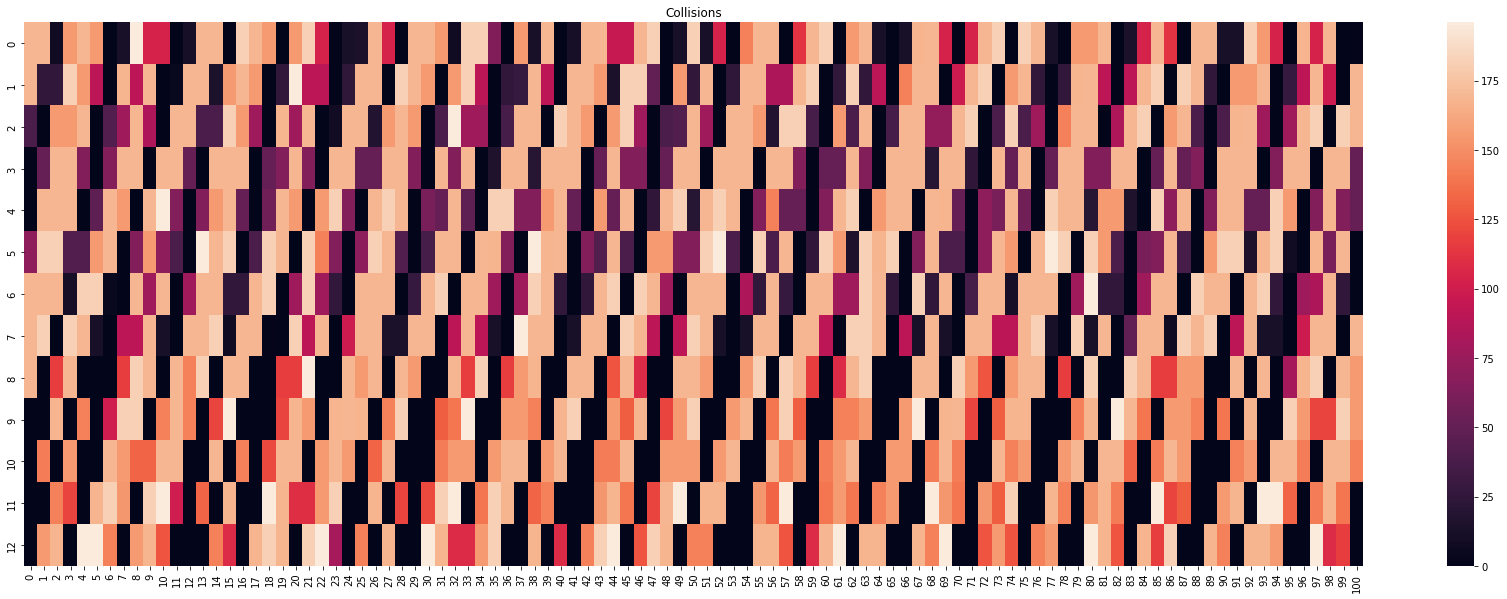

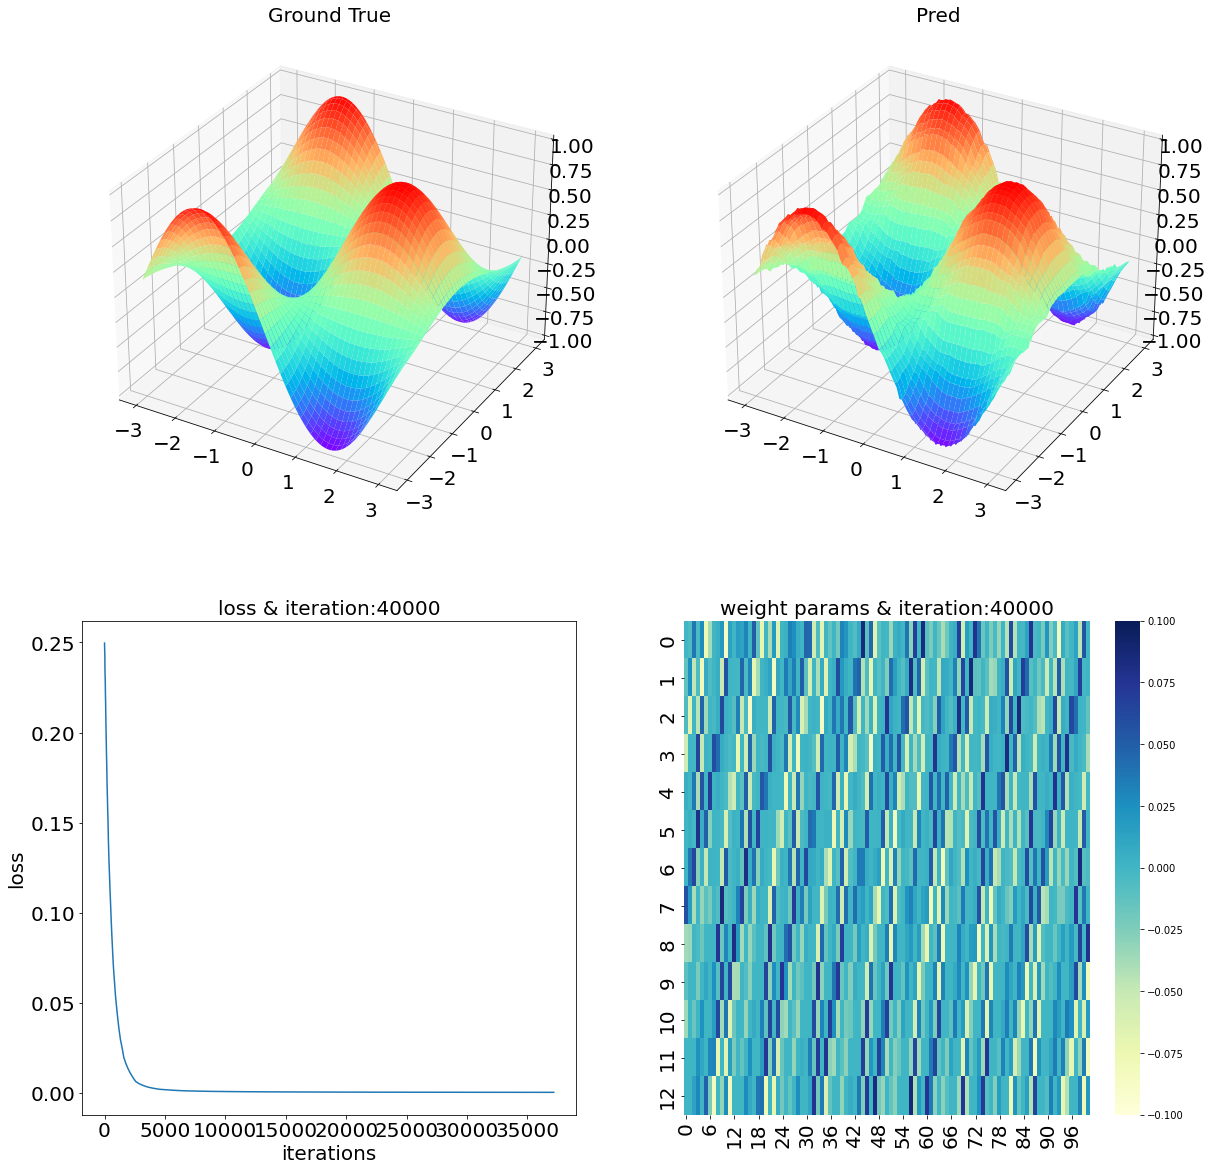

In [21]:
# ---------------------------- 绘图 ------------------------
# 探测碰撞
real_address_heatmap = np.zeros((expend_dim, hash_number))
for train_sample in train_x_list:
    pred_y = my_cmac.forward(train_sample)
    real_address_heatmap[range(0, my_cmac.expend_dim), my_cmac.real_vector.reshape(-1)-1] += 1

plt.figure(figsize=(30, 10))
plt.title("Collisions")
sn.heatmap(real_address_heatmap)
plt.show()

# 绘制训练过程图
fig = plt.figure(figsize=(20, 20))
for i in range(len(train_loss_dict)):
    plt.cla()
    plt.clf()
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.set_title("Ground True", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax1.tick_params(axis='z', labelsize=20)
    ax1.set_zlim(-1, 1)
    ax1.plot_surface(x1, x2, np.sin(x1) * np.cos(x2), cmap="rainbow")

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    ax2.set_title("Pred", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax2.tick_params(axis='z', labelsize=20)
    ax2.set_zlim(-1, 1)
    ax2.plot_surface(x1, x2, train_pred_recoder[i].reshape((sample_resolution, sample_resolution)), cmap="rainbow")

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("loss & iteration:{}".format(list(train_loss_dict.keys())[i]), fontsize=20)
    ax3.set_xlabel("iterations", fontsize=20)
    ax3.set_ylabel("loss", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax3.plot(list(train_loss_dict.keys())[:i], list(train_loss_dict.values())[:i])
    ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable="box")

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("weight params & iteration:{}".format(list(train_loss_dict.keys())[i]), fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sn.heatmap(params_recoder[i], vmax=0.1, vmin=-0.1, cmap="YlGnBu")

    plt.savefig("./images/temp/{}.png".format(i), dpi=70)
plt.show()

with imageio.get_writer("./images/{}.gif".format("CMAC_sin_cos"), mode="I", fps=10) as Writer:
    for ind in range(len(train_loss_dict)):
        image = imageio.imread("./images/temp/{}.png".format(ind))
        os.remove("./images/temp/{}.png".format(ind))
        Writer.append_data(image)